<a href="https://colab.research.google.com/github/Rajeeb321123/Pytorch/blob/master/03_1_Yolo_fromScratch_compter_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References
The codes in this notebook use reference from the following sources

- https://github.com/jahongir7174/YOLOv8-dfl/tree/master
- https://arxiv.org/html/2304.00501v6/#S16
- https://github.com/ultralytics/ultralytics/tree/main/ultralytics/models/yolo

## Original Yolov8

In [1]:
%%capture
# Install the ultralytics package from PyPI
!pip install ultralytics

In [2]:
# import
import math, os, random, cv2, numpy, torch
import torch.nn as nn
from ultralytics import YOLO

# explore the original yolov8 model

# original yolov8n
model_n=YOLO('yolov8n.pt')
print(f"yolov8-nano: {sum(p.numel() for p in model_n.parameters())/1e6} million parameters")


# model_s=YOLO('yolov8s.pt')
# print(f"yolov8-small: {sum(p.numel() for p in model_s.parameters())/1e6} million parameters")

print(model_n.model)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 66.4MB/s]


yolov8-nano: 3.1572 million parameters
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       

# Yolov8 architecture

The overall architecture is BackBone + Neck + Head

In [3]:
%%capture
!wget https://github.com/dtdo90/yolov8_detection/blob/main/yolov8_architecture.png?raw=true -O yolov8_architecture.png


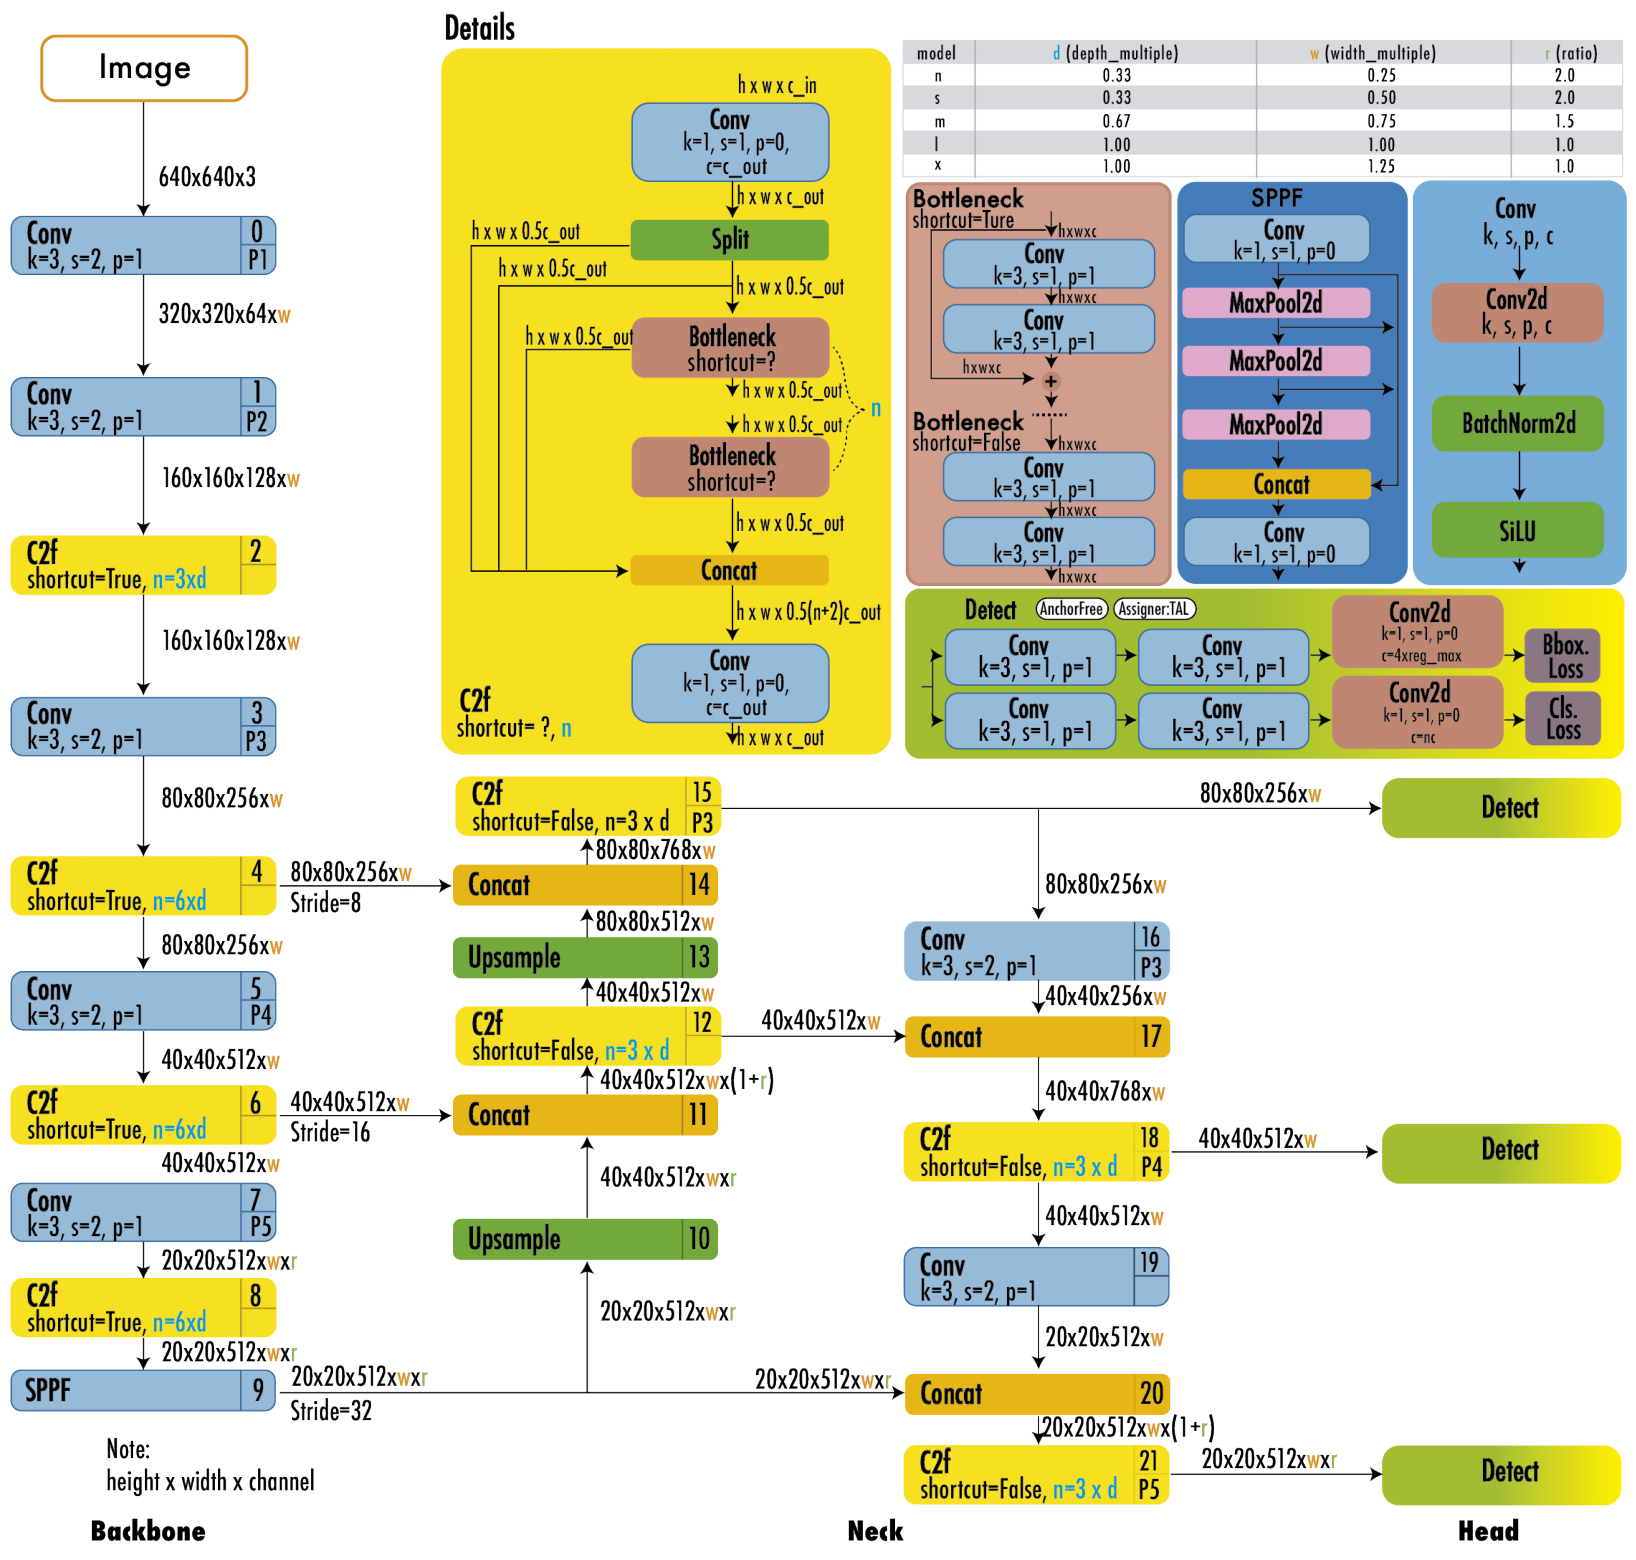

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/yolov8_architecture.png') #Replace "image.jpg" with the path of your image
plt.figure(figsize=(30, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

##1. Backbone

The backbone is modified CSPDarknet53 which comprises of blocks Conv, C2f, SPPF
- Conv: Conv2d + BatchNorm2d + SiLU

- C2f (cross-stage partial bottleneck with 2 convolutions): Conv + Bottlenecks + Conv

- Combine high-level features with contextual information to improve detection accuracy.

- SPPF (spatial pyramid pooling fast): Conv + Maxpool2d + Conv
Process features at various scales and pool them into a fixed-size feature map.

###(1) Conv

In [5]:
class Conv(nn.Module):
    def __init__(self,in_channels, out_channels,kernel_size=3,stride=1,padding=1,groups=1,activation=True):
      super().__init__()
      self.conv=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,groups=groups,bias=False)
      self.bn= nn.BatchNorm2d(out_channels, eps = 0.01, momentum = 0.03)
      self.act=nn.SiLU() if activation else nn.Identity()

    def forward(self,x):
      return self.act(self.bn(self.conv(x)))

# sanity check
conv=Conv(in_channels=3,out_channels=64)
print(f"{sum(p.numel() for p in conv.parameters())/1e6} million parameters")

dummy_input=torch.rand((1,3,244,244))
dummy_input=conv(dummy_input)
print("Output shape: ", dummy_input.shape)

0.001856 million parameters
Output shape:  torch.Size([1, 64, 244, 244])


### (2) C2F

The C2f (Coarse-to-Fine) module is a component used in some modern convolutional neural networks (CNNs), such as YOLOv8, to enhance the feature extraction process. The idea behind the C2f module is to capture features at multiple scales, starting from coarse (low-resolution) features and refining them to finer (high-resolution) features. This approach helps in improving the accuracy and robustness of the model.

Real-Time Performance: The efficiency of the C2f module ensures that the model can be used in real-time applications without significant computational overhead.


**Key Characteristics of C2f:**

- Multi-Scale Feature Extraction: The C2f module processes the input at different scales, allowing the network to capture both global and local features effectively.

- Hierarchical Representation: By combining coarse and fine features, the C2f module creates a hierarchical representation that improves the model's ability to detect objects at various scales.

- Efficiency: The C2f module is designed to be computationally efficient, making it suitable for real-time applications like object detection.

In [6]:
# 2.1 Bottleneck: staack of 2 COnv with shortcut connnection (True/False)
class Bottleneck(nn.Module):
    def __init__(self,in_channels,out_channels,shortcut=True):
        super().__init__()
        self.conv1=Conv(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.conv2=Conv(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.shortcut=shortcut # there are other way to use shortcut or residual connection as well or conv1x1(x) any many more

    def forward(self,x):
        x_in=x # for residual connection
        x=self.conv1(x)
        x=self.conv2(x)
        if self.shortcut:
            x=x+x_in
        return x

# 2.2 C2f: Conv + bottleneck*N+ Conv
class C2f(nn.Module):
    def __init__(self,in_channels,out_channels, num_bottlenecks,shortcut=True):
        super().__init__()

        self.mid_channels=out_channels//2
        self.num_bottlenecks=num_bottlenecks

        self.conv1=Conv(in_channels,out_channels,kernel_size=1,stride=1,padding=0)

        # sequence of bottleneck layers
        self.m=nn.ModuleList([Bottleneck(self.mid_channels,self.mid_channels) for _ in range(num_bottlenecks)])

        self.conv2=Conv((num_bottlenecks+2)*out_channels//2,out_channels,kernel_size=1,stride=1,padding=0) # why in channel shape is like that do some simple calculation looking at code below. very simple.

    def forward(self,x):
        x=self.conv1(x)

        # split x along channel dimension
        x1,x2=x[:,:x.shape[1]//2,:,:], x[:,x.shape[1]//2:,:,:] # we can use torch.chunk as well
        # x1, x2 = torch.chunk(x, 2, dim=1)
        # x2 is kept unchanged: reducing computaion and preserving original features. in torch.cat below

        # list of outputs
        outputs=[x1,x2] # x1 is fed through the bottlenecks

        for i in range(self.num_bottlenecks):
            x1=self.m[i](x1)    # [bs,0.5c_out,w,h]
            outputs.insert(0,x1) # add x1 to list outputs

        outputs=torch.cat(outputs,dim=1) # [bs,0.5c_out(num_bottlenecks+2),w,h]
        out=self.conv2(outputs)

        return out

# sanity check
c2f=C2f(in_channels=64,out_channels=128,num_bottlenecks=2)
print(f"{sum(p.numel() for p in c2f.parameters())/1e6} million parameters")

dummy_input=torch.rand((1,64,244,244))
dummy_input=c2f(dummy_input)
print("Output shape: ", dummy_input.shape)

0.18944 million parameters
Output shape:  torch.Size([1, 128, 244, 244])


### (3) SPPF

- for maxpool2d the padding to main the the original spatial dimension should be :
$$ p = \left\lceil \frac{(k - 1) \times s + 1 - s}{2} \right\rceil $$

- Dilation = 1 (default): No spacing between kernel elements. The kernel moves across the input without skipping any elements.
```
[a, b, c]
[d, e, f]
[g, h, i]
```


- Dilation > 1: The kernel elements are spaced out, effectively enlarging the receptive field of the kernel without increasing the kernel size itself. This means the convolution operation skips over certain elements in the input.
```
for d = 2
[a, 0, b, 0, c]
[0, 0, 0, 0, 0]
[d, 0, e, 0, f]
[0, 0, 0, 0, 0]
[g, 0, h, 0, i]
```

- ceil_mode = False: The output size is calculated using the floor function, which means the output dimension is rounded down to the nearest integer.

- ceil_mode = True: The output size is calculated using the ceiling function, which means the output dimension is rounded up to the nearest integer.



In [7]:
class SPPF(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size_max_pool=5):
        super().__init__()
        hidden_channels=in_channels//2
        self.conv1 = Conv(in_channels,hidden_channels,kernel_size=1, stride=1, padding=0)
        self.conv2 = Conv(4*hidden_channels, out_channels,kernel_size=1, stride=1, padding=0) #4 because look at figure properly.
        self.m=nn.MaxPool2d(kernel_size=kernel_size_max_pool, stride=1, padding=kernel_size_max_pool//2, ceil_mode=False, dilation=1)

    def forward(self,x):
        x=self.conv1(x)

        # apply maxpooling at diffent scales
        y1=self.m(x)
        y2=self.m(y1)
        y3=self.m(y2)

        # concantenate
        y=torch.cat([x,y1,y2,y3],dim=1) # we always use dim = 1 becaues be want to concat by channel: (batch, channel, width , height)

        # final conv
        y=self.conv2(y)

        return y

# sanity check
sppf=SPPF(in_channels=128,out_channels=512)
print(f"{sum(p.numel() for p in sppf.parameters())/1e6} million parameters")

dummy_input=sppf(dummy_input)
print("Output shape: ", dummy_input.shape)

0.140416 million parameters
Output shape:  torch.Size([1, 512, 244, 244])


### Puting all together

- n (Nano):
```
d = 1/3: Depth scaling factor (reduces the number of layers or blocks).
```
```
w = 1/4: Width scaling factor (reduces the number of channels in each layer).
```
```
r = 2.0: Resolution scaling factor (increases the input resolution).
```

In [8]:
# backbone = DarkNet53

# return d,w,r based on version depth_multiple (for c2f), width_multiple, r = depth width ratio. Look at figrue above
def yolo_params(version):
    if version=='n': # we are using nano
        return 1/3,1/4,2.0
    elif version=='s':
        return 1/3,1/2,2.0
    elif version=='m':
        return 2/3,3/4,1.5
    elif version=='l':
        return 1.0,1.0,1.0
    elif version=='x':
        return 1.0,1.25,1.0

class Backbone(nn.Module):
    def __init__(self,version,in_channels=3,shortcut=True):
        super().__init__()
        d,w,r=yolo_params(version)

        # conv layers
        self.conv_0=Conv(in_channels,int(64*w),kernel_size=3,stride=2,padding=1)
        self.conv_1=Conv(int(64*w),int(128*w),kernel_size=3,stride=2,padding=1)
        self.conv_3=Conv(int(128*w),int(256*w),kernel_size=3,stride=2,padding=1)
        self.conv_5=Conv(int(256*w),int(512*w),kernel_size=3,stride=2,padding=1)
        self.conv_7=Conv(int(512*w),int(512*w*r),kernel_size=3,stride=2,padding=1)

        # c2f layers
        self.c2f_2=C2f(int(128*w),int(128*w),num_bottlenecks=int(3*d),shortcut=True)
        self.c2f_4=C2f(int(256*w),int(256*w),num_bottlenecks=int(6*d),shortcut=True)
        self.c2f_6=C2f(int(512*w),int(512*w),num_bottlenecks=int(6*d),shortcut=True)
        self.c2f_8=C2f(int(512*w*r),int(512*w*r),num_bottlenecks=int(3*d),shortcut=True)

        # sppf
        self.sppf=SPPF(int(512*w*r),int(512*w*r))

    def forward(self,x):
        x=self.conv_0(x)
        x=self.conv_1(x)

        x=self.c2f_2(x)

        x=self.conv_3(x)

        out1=self.c2f_4(x) # keep for output

        x=self.conv_5(out1)

        out2=self.c2f_6(x) # keep for output

        x=self.conv_7(out2)
        x=self.c2f_8(x)
        out3=self.sppf(x)

        return out1,out2,out3

print("----Nano model -----")
backbone_n=Backbone(version='n')
print(f"{sum(p.numel() for p in backbone_n.parameters())/1e6} million parameters")

print("----Small model -----")
backbone_s=Backbone(version='s')
print(f"{sum(p.numel() for p in backbone_s.parameters())/1e6} million parameters")

----Nano model -----
1.272656 million parameters
----Small model -----
5.079712 million parameters


## Neck

The neck comprises of Upsample + C2f with

Upsample = nearest-neighbor interpolation with scale_factor=2. It doesn't have trainable paramaters.

- Nearest-neighbor interpolation is a simple and efficient method for upsampling or resizing images and tensors. It works by replicating the value of the nearest pixel or element when increasing the resolution of the input. Simple calculation only



### Upsample

In [11]:
# upsample = nearest-neighbor interpolation with scale_factor=2
#            doesn't have trainable paramaters
class Upsample(nn.Module):
    def __init__(self,scale_factor=2,mode='nearest'):
        super().__init__()
        self.scale_factor=scale_factor
        self.mode=mode

    def forward(self,x):
        return nn.functional.interpolate(x,scale_factor=self.scale_factor,mode=self.mode)

# sanity check
upsample=Upsample()
print(f"{sum(p.numel() for p in upsample.parameters())/1e6} million parameters")

dummy_input=torch.rand((1,512, 20, 20))
dummy_input=upsample(dummy_input)
print("Output shape: ", dummy_input.shape)

0.0 million parameters
Output shape:  torch.Size([1, 512, 40, 40])


### Puting all Together

In [12]:
class Neck(nn.Module):
    def __init__(self,version):
        super().__init__()
        d,w,r=yolo_params(version)

        self.up=Upsample() # no trainable parameters
        self.c2f_1=C2f(in_channels=int(512*w*(1+r)), out_channels=int(512*w),num_bottlenecks=int(3*d),shortcut=False)
        self.c2f_2=C2f(in_channels=int(768*w), out_channels=int(256*w),num_bottlenecks=int(3*d),shortcut=False)
        self.c2f_3=C2f(in_channels=int(768*w), out_channels=int(512*w),num_bottlenecks=int(3*d),shortcut=False)
        self.c2f_4=C2f(in_channels=int(512*w*(1+r)), out_channels=int(512*w*r),num_bottlenecks=int(3*d),shortcut=False) # just do simple example how concatenation work. very very easy

        self.cv_1=Conv(in_channels=int(256*w),out_channels=int(256*w),kernel_size=3,stride=2, padding=1)
        self.cv_2=Conv(in_channels=int(512*w),out_channels=int(512*w),kernel_size=3,stride=2, padding=1)


    def forward(self,x_res_1,x_res_2,x):
        # x_res_1,x_res_2,x = output of backbone
        res_1=x              # for residual connection

        x=self.up(x)
        x=torch.cat([x,x_res_2],dim=1)

        res_2=self.c2f_1(x)  # for residual connection

        x=self.up(res_2)
        x=torch.cat([x,x_res_1],dim=1)

        out_1=self.c2f_2(x)

        x=self.cv_1(out_1)

        x=torch.cat([x,res_2],dim=1)
        out_2=self.c2f_3(x)

        x=self.cv_2(out_2)

        x=torch.cat([x,res_1],dim=1)
        out_3=self.c2f_4(x)

        return out_1,out_2,out_3

# sanity check
neck=Neck(version='n')
print(f"{sum(p.numel() for p in neck.parameters())/1e6} million parameters")

x=torch.rand((1,3,640,640))
out1,out2,out3=Backbone(version='n')(x)
out_1,out_2,out_3=neck(out1,out2,out3)
print(out_1.shape)
print(out_2.shape)
print(out_3.shape)

0.98688 million parameters
torch.Size([1, 64, 80, 80])
torch.Size([1, 128, 40, 40])
torch.Size([1, 256, 20, 20])


## Head

Consist of 3 modules: (1) bbox coordinates, (2) classification scores, (3) distribution focal loss (DFL).



### Learning phase

- A bounding box is a rectangular box used in object detection and computer vision tasks to specify the location of an object within an image. The coordinates of the bounding box are usually given by two points: the top-left corner and the bottom-right corner of the rectangle.

In [1]:

import torch

# Simple Box format
# Sample bounding box coordinates (x_min, y_min, x_max, y_max)
bbox = torch.tensor([50, 30, 200, 150])

# Calculate width and height
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]

# Calculate center coordinates
cx = (bbox[0] + bbox[2]) / 2
cy = (bbox[1] + bbox[3]) / 2

print("Width:", width)
print("Height:", height)
print("Center:", (cx, cy))


# Yolo Box format
# Sample YOLO output (cx, cy, w, h, confidence, class_probabilities)
# Confidence Score: Indicates the confidence that the box contains an object.
# Class Probabilities: Indicates the probabilities for each object class.
yolo_output = torch.tensor([0.5, 0.5, 0.4, 0.3, 0.9, 0.1, 0.8, 0.1])

# Extract components
cx, cy, w, h, confidence = yolo_output[:5]
class_probabilities = yolo_output[5:]

print("Center:", (cx, cy))
print("Width:", w)
print("Height:", h)
print("Confidence:", confidence)
print("Class Probabilities:", class_probabilities)


Width: tensor(150)
Height: tensor(120)
Center: (tensor(125.), tensor(90.))
Center: (tensor(0.5000), tensor(0.5000))
Width: tensor(0.4000)
Height: tensor(0.3000)
Confidence: tensor(0.9000)
Class Probabilities: tensor([0.1000, 0.8000, 0.1000])


- Classification score

Class Probabilities:
The class probabilities are a set of values that indicate the likelihood of each class being present in the bounding box. For example, if the model is trained to detect three classes (e.g., person, car, dog), the class probabilities might look like this: 0.1, 0.8, 0.1


In [2]:
import torch

# Example YOLOv8 output (batch_size, num_predictions, 5 + num_classes)
# 5: [cx, cy, w, h, confidence]
# num_classes: probabilities for each class
yolov8_output = torch.randn(1, 100, 5 + 80)  # Example output with 80 classes

# Extract the class probabilities for the first prediction
class_probs = yolov8_output[0, 0, 5:]
predicted_class = class_probs.argmax().item()
print("Class Probabilities:", class_probs)
print("Predicted Class:", predicted_class)

Class Probabilities: tensor([ 1.2696, -1.6611, -0.5095, -0.7525, -0.3734,  1.0505,  2.5411, -1.3673,
         0.4864,  1.6752,  0.1535, -1.5804, -1.2518, -0.5078,  1.6350,  1.1138,
         0.0115,  1.7193, -0.1064,  1.3186,  2.1078, -0.9657, -0.8072,  1.2376,
        -1.0544, -1.1866,  1.4736, -0.4131,  1.4528, -0.4585, -0.0794, -2.3261,
         1.5691,  0.7506, -1.4278,  0.6003,  0.2540, -0.2100,  0.7947, -1.1766,
         0.3044, -0.3539, -0.4094,  0.8868,  1.6945, -0.4496,  0.8062,  0.2806,
         0.3425, -0.5519,  0.5771,  2.3673, -0.4958, -0.2050, -0.4473,  0.9192,
        -1.1721,  0.6741, -0.1396, -1.1100,  0.5580, -1.0823,  0.5516,  0.3345,
         1.3583, -1.3341,  0.7796, -1.0373,  0.3374,  0.6069, -1.5525, -0.8118,
        -0.1091,  1.6092,  0.0486, -0.1532, -0.0165, -0.1571,  1.8375,  0.0868])
Predicted Class: 6




Note: we are using dfl for also prediction. below code is for finding dfl loss. use


DFL loss: we use dfl loss function to update weights
Ask chat gpt to show mathematics of below code with real life example. very easy.

- Distribution Focal Loss (DFL) is a specialized loss function used in object detection tasks, particularly for bounding box regression. It was introduced as part of the Generalized Focal Loss (GFL) framework, which aims to improve the accuracy and robustness of object detection models by addressing the limitations of traditional loss functions.

-  DFL uses a vector to represent the distribution of bounding box coordinates. For example, if the left boundary of a bounding box is at 5.6, DFL represents this as a distribution between 5 and 6, with weights assigned to each value based on their proximity to the actual coordinate.

- Traditional methods often treat the bounding box coordinates as fixed values. However, DFL considers the bounding box coordinates as a distribution, which can better capture the uncertainty and variability in object localization

- DFL helps in refining the box predictions by learning how likely each bin is to be the correct location.

In [3]:
# A bin represents a small discrete interval in a continuous space.
# For example, if a coordinate (like x) can be in the range [0, 100], and we divide this range into 10 bins, each bin would cover an interval
#Here, bin 5 (50-60) has the highest probability (0.30), but nearby bins (4 and 6) also have some probability. The final predicted coordinate is computed as a weighted sum of bin centers.

import torch
import torch.nn as nn
import torch.nn.functional as F

class DistributionFocalLoss(nn.Module):
    """Distribution Focal Loss used in YOLO for bounding box refinement."""
    def __init__(self):
        super(DistributionFocalLoss, self).__init__()

    def forward(self, pred, target):
        """
        :param pred: Tensor of shape (B, C) where C is the number of bins (e.g., 16 or 32).
        :param target: Tensor of shape (B,) with continuous values representing the target.
        :return: Scalar loss value.
        """
        pred = pred.view(-1, pred.shape[-1])  # Flatten
        target = target.view(-1)  # Ensure target shape is (B,)

        # Compute softmax probabilities
        prob = F.softmax(pred, dim=1)

        # Convert target into two nearest bin indices
        left_idx = target.long()
        right_idx = torch.clamp(left_idx + 1, max=pred.shape[-1] - 1)

        # Compute interpolation weights
        right_weight = target - left_idx.float()
        left_weight = 1.0 - right_weight

        # Compute final loss
        loss = -(
            left_weight * torch.log(prob.gather(1, left_idx.unsqueeze(1)).squeeze(1) + 1e-9) +
            right_weight * torch.log(prob.gather(1, right_idx.unsqueeze(1)).squeeze(1) + 1e-9)
        )

        return loss.mean()

dfl = DistributionFocalLoss()

# Create random test input
batch_size = 4
num_bins = 16  # Example: 16 bins for bounding box coordinate

# Generate random logits (before softmax) for each bin
random_preds = torch.randn(batch_size, num_bins)  # Shape: (4, 16)

# Generate random continuous target values (assume they fall in bin index range)
random_targets = torch.randint(0, num_bins - 1, (batch_size,), dtype=torch.float32) + torch.rand(batch_size)

# Initialize and compute loss
dfl = DistributionFocalLoss()
loss_value = dfl(random_preds, random_targets)

print("Random Predictions (logits):\n", random_preds)
print("\nRandom Target Values:\n", random_targets)
print("\nComputed DFL Loss:", loss_value.item())


Random Predictions (logits):
 tensor([[ 0.2997,  0.2299, -0.3045,  0.6408, -0.8426, -0.6770, -0.5796, -0.4923,
          0.3242, -1.1770, -0.3747,  1.2074,  0.0903,  0.7493, -0.2961, -0.4938],
        [ 2.6965,  0.8869,  0.8317,  0.5203,  1.2118,  0.6116, -1.8026,  0.1433,
          0.0487,  1.0273, -0.0649,  0.8000, -0.5127,  0.9724,  1.8085,  0.8989],
        [ 0.1005, -0.3757,  0.6701, -1.6829, -1.4102, -0.5495,  0.1086,  0.2633,
          1.1506, -1.4292,  0.9165, -0.0445,  0.3930,  0.4015,  1.1376,  0.2205],
        [ 2.5002,  0.0367, -0.3638, -0.1953, -0.8420, -0.8695, -0.0730,  0.6503,
         -1.2310, -1.3836, -0.8580, -0.1951,  0.2354, -0.2370, -1.2453,  0.5589]])

Random Target Values:
 tensor([14.3412,  9.5074, 10.7982,  5.3986])

Computed DFL Loss: 3.3142685890197754


### (1) DFL

different to dfl loss: This class (DFL) is used in the forward pass of the model to predict coordinates.

In [23]:
# DFL
class DFL(nn.Module):
    def __init__(self,ch=16):
      # we are just find bin, y_pred use chat gpt to go through .It may be little difficult how shape are changing
        super().__init__()

        self.ch=ch # no of bins

        self.conv=nn.Conv2d(in_channels=ch,out_channels=1,kernel_size=1,bias=False).requires_grad_(False)

        # initialize conv with [0,...,ch-1]
        x=torch.arange(ch,dtype=torch.float).view(1,ch,1,1)
        self.conv.weight.data[:]=torch.nn.Parameter(x) # DFL only has ch parameters # directly modify the conv without gradient tracking

    def forward(self,x):
        # x must have num_channels = 4*ch: x=[bs,4*ch,a]
        b,c,a=x.shape                           # c=4*ch

        x=x.view(b,4,self.ch,a).transpose(1,2)  # [bs,ch,4,a]

        # take softmax on channel dimension to get distribution probabilities
        x=x.softmax(1)                          # [b,ch,4,a] softmax along dim =1 or ch
        x=self.conv(x)         # we find y_pred = sum( each_channel_prob * bin) # [b,1,4,a]
        return x.view(b,4,a)                    # [b,4,a]

# sanity check
dummy_input=torch.rand((1,64,128))
dfl=DFL()
print(f"{sum(p.numel() for p in dfl.parameters())} parameters")

dummy_output=dfl(dummy_input)
print(dummy_output.shape)

print(dfl)

16 parameters
torch.Size([1, 4, 128])
DFL(
  (conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
